In [1]:
import numpy as np
import sys
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import interferometer as itf
from scipy.linalg import expm, logm
sys.path.append('../') # Add parent directory to the system path

In [2]:
# This import requires previous directory to be appended to sys.path
from direct_decomposition import direct_decomposition, random_unitary
# from numeric_truncated_unitaries import pad_matrix

In [3]:
def a(n):
    """
    Annihilation operator truncated at n photons, 
    """
    d = n + 1 # The unpadded creation operator truncated at n photons has dimension dxd
    matrix = np.zeros((d, d))
    for i in range(1, d):
        matrix[i-1, i] = np.sqrt(i)
    # matrix = pad_matrix(matrix) # Pad with zeros
    return matrix

def ad(n):
    """
    Creation operator truncated at n photons
    """
    return np.transpose(a(n))

In [4]:
def op_basis_element(M, N, i, j):
    """
    Get the (i,j)th basis element of an M mode interferometer supporting up to N photons
    Where i is the index of the creation operator and j is the index of the annihilation operator

    Example 1:
    (M = 3, N = 2, i = 1, j = 1)

    $$ I_{(N=2)} \otimes a^\dagger_{(N=2)} a_{(N=2)} \otimes I_{(N=2)} $$

    Example 2:
    (M = 4, N = 4, i = 0, j = 3)

    $$ a^\dagger_{(N=4)} \otimes I_{(N=4)} \otimes I_{(N=4)} \otimes a_{(N=4)} $$
    """

    def get_kronecker_term(idx):
        """
        Find the kth term in the kronecker product of the basis element where k = idx.

        Example:
            Suppose the basis operator has the form
            $$a_{(N)}^\dagger \otimes a_{(N)} $$

            get_kronecker_term(1) would $a_{(N)}^\dagger$.
        """
        if idx == i and idx == j:
            return ad(N) @ a(N)
        elif idx == i:
            return ad(N)
        elif idx == j:
            return a(N)
        else:
            return np.eye(N+1, N+1) 
            # Plus one since this happens implicitly in the a() and ad() functions

    assert(i < M and j < M), "Index or indices out of range"
    basis_element = get_kronecker_term(0)
    for k in range(1, M):
        kron_term = get_kronecker_term(k)
        basis_element = np.kron(basis_element, kron_term)
    return basis_element


Test case: $M = 2$, $N = 2$, $i = 0$, $j = 1$
$$
\begin{pmatrix}
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

In [5]:
# Comparing test case to mathematica output:
test_element = op_basis_element(2, 2, 0, 1)
print(np.shape(test_element))
print(np.array_str(test_element))
# Output matches

(9, 9)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.41421356 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         2.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]


In [6]:
def expanded_unitary(U, N):
    """
    This function takes a unitary U corresponding to the action of an M mode interferometer on the 
    creation operators and returns a unitary in the second quantization picture that can support up
    to N photons per mode.
    """
    M = np.shape(U)[0]
    # Get Hamiltonian from unitary:
    H = -1j * logm(U)
    expanded_H = 0
    # Sum basis elements multiplied by the corresponding Hamiltonian terms
    for i in range(M):
        for j in range(M):
            expanded_H += H[i][j] * op_basis_element(M, N, i, j)
    return expm(1j * expanded_H)

In [7]:
# Test expanded_unitary
r2 = 1/np.sqrt(2)
test_U = np.matrix([[r2, r2, 0],[r2,-r2,0],[0,0,1]])
U_expd = expanded_unitary(test_U, 2)
print(np.shape(U_expd))
print(sum(np.diag(U_expd)))
# Expected value of checksum:
# 9. + 4.7475 i 
# Verified by Mathematica


(27, 27)
(9.000000000000004+4.747500951788335j)


In [49]:
R = random_unitary(3)
U_expd = expanded_unitary(R, 3)
print(R)
print(np.shape(U_expd))

[[-0.60196435+0.29963861j -0.57065695-0.0694505j  -0.46405867+0.04508269j]
 [-0.50963968-0.51819734j  0.03432341+0.60328498j  0.21764556+0.24338952j]
 [-0.0863485 -0.11017472j  0.39959603-0.38042007j -0.32000611+0.75736724j]]
(64, 64)


In [70]:
# Initialize statevector
ket_0 = np.matrix([1,0])
ket_1 = np.matrix([0,1])

# state_vector = [0,0,0,0,0,1]
state_vector = [0,1,0,1,0,0]

# Tidy me
if state_vector[0] == 0:
    initial_state = ket_0
elif state_vector[0] == 1:
    initial_state = ket_1

for qubit in state_vector[1::]:
    if qubit == 0:
        initial_state = np.kron(initial_state, ket_0)
    if qubit == 1:
        initial_state = np.kron(initial_state, ket_1)

initial_state = np.transpose(initial_state)

v = U_expd @ initial_state
print(np.square(np.abs(v)))

[[0.        ]
 [0.        ]
 [0.01192901]
 [0.        ]
 [0.        ]
 [0.1185278 ]
 [0.        ]
 [0.        ]
 [0.38576885]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.18160512]
 [0.        ]
 [0.        ]
 [0.00332644]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.29884277]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


{'000101': 1, '010001': 23, '001000': 33, '000010': 31, '010100': 12}


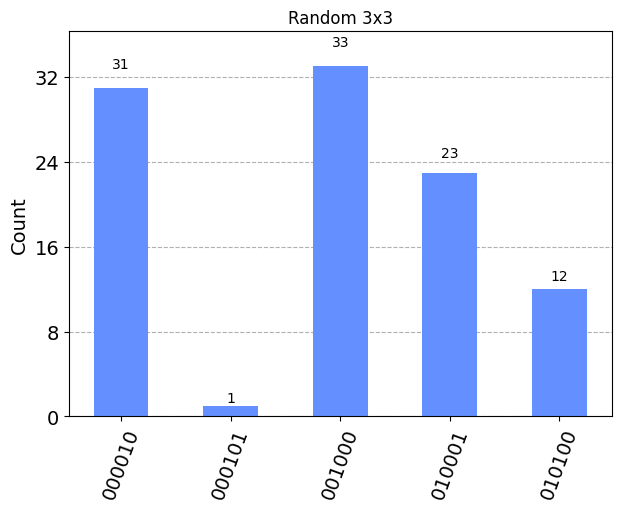

In [83]:
# Circuit simulation:
circuit = QuantumCircuit(6)
circuit.initialize("000101")
interferom = direct_decomposition(R, 2)
circuit.compose(interferom, qubits=list(range(6)), inplace=True)
circuit.measure_all()

num_shots = 100
simulator = AerSimulator()
circuit = transpile(circuit, simulator)
result = simulator.run(circuit, shots=num_shots).result()
counts = result.get_counts(circuit)
print(counts)
plot_histogram(counts, title='Random 3x3')

In [ ]:
|